In [3]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../data/hr_raw_data_definitivo.csv', index_col=0)
df.head()

,employee_number,attrition,job_level,job_role,department,monthly_income,salary,percent_salary_hike,training_times_last_year,stock_option_level,...,age,gender,marital_status,education,education_field,num_companies_worked,total_working_years,years_at_company,years_since_last_promotion,years_with_curr_manager
0,1,No,5,research director,research & development,16280.83,195370.00,13,5,0,...,52,M,NaN,3,other,7,NaN,20,15,15
1,2,No,5,manager,general,16665.83,199990.00,14,5,1,...,53,M,NaN,4,life sciences,0,34.0,33,11,9
2,3,No,5,manager,research & development,16026.67,192320.00,11,3,0,...,43,M,married,2,technical degree,1,22.0,22,11,15
3,4,No,4,research director,research & development,14307.50,171690.00,19,2,2,...,48,F,married,4,medical,3,NaN,20,5,6
4,5,No,4,sales executive,sales,12783.92,153407.04,12,5,1,...,47,F,divorced,3,technical degree,2,NaN,19,2,8


In [5]:
grupo_control = df[df['satisfaction'] == 'satisfied']

In [6]:
grupo_variante = df[df['satisfaction'] == 'not satisfied']

In [7]:
grupo_control_porcentaje_rotacion = grupo_control[grupo_control['attrition'] == 'Yes']["employee_number"].count()/grupo_control.shape[0]*100
print(grupo_control_porcentaje_rotacion)

13.668341708542714


In [8]:
grupo_variante_porcentaje_rotacion = grupo_variante[grupo_variante['attrition'] == 'Yes']["employee_number"].count()/grupo_variante.shape[0]*100
print(grupo_variante_porcentaje_rotacion)

19.87075928917609


### Marina y Fiona - 25.11.2024

    H0 = No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.
    H1 = Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.

In [9]:
'''Hacemos una tabla de contingencia, ya que son dos variables categóricas, para ver las proporciones.'''
tabla_contingencia = pd.crosstab(df["satisfaction"], df["attrition"])

In [10]:
tabla_contingencia

attrition,No,Yes
satisfaction,,
not satisfied,496,123
satisfied,859,136


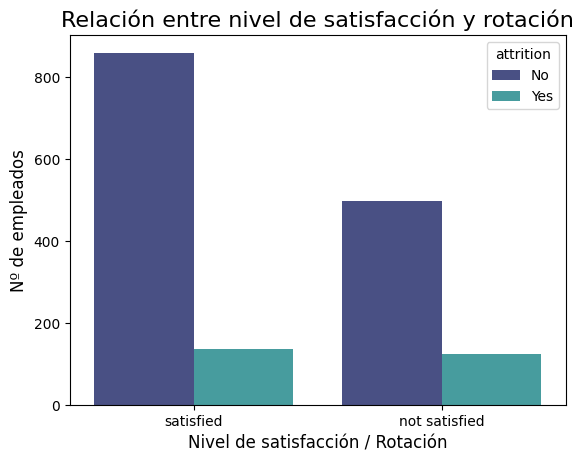

In [35]:
plot = sns.countplot( x="satisfaction", data=df, hue='attrition', palette="mako") 
plot.set_title("Relación entre nivel de satisfacción y rotación", fontsize=16) 
plot.set_xlabel("Nivel de satisfacción / Rotación", fontsize=12) 
plot.set_ylabel("Nº de empleados", fontsize=12);

In [12]:
'''Confirmar si nos quedamos con la H0 o la H1. En este caso calculamos el chi2 al tratarse de variables categóricas (proporciones).'''

_, p_value, _, _ = chi2_contingency(tabla_contingencia)
if p_value <= 0.05:
    print('Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.')
else:
    print('No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.')

Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.


Rechazamos H0 y nos quedamos con la H1 - Existe una relación significativa entre el nivel de satisfacción y la rotación. 

### ¿Existe relación entre el salario y el nivel de rotación de los empleados?
    H0 = No existe relación entre el salario y el nivel de rotación de os empleados.
    H1 = Existe relación entre el salario y el nivel de rotación de os empleados.

In [13]:
grupo_control_rotacion = df[df['attrition'] == 'No']

In [14]:
grupo_variante_rotacion = df[df['attrition'] == 'Yes']

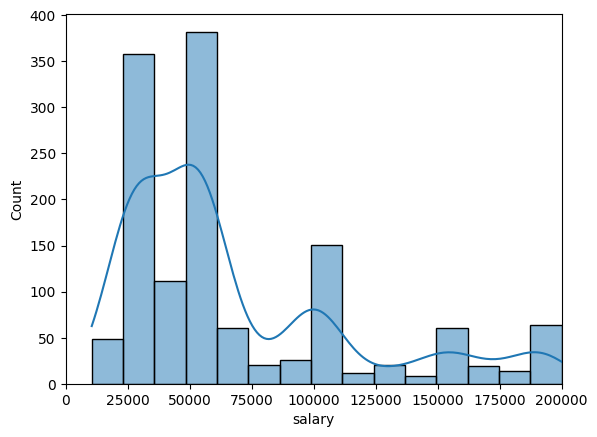

In [36]:
'''Visualización distribución salarios de empleados satisfechos.'''
sns.histplot(x= 'salary', data= grupo_control_rotacion, kde=True)
plt.xlim(0, 200000); 

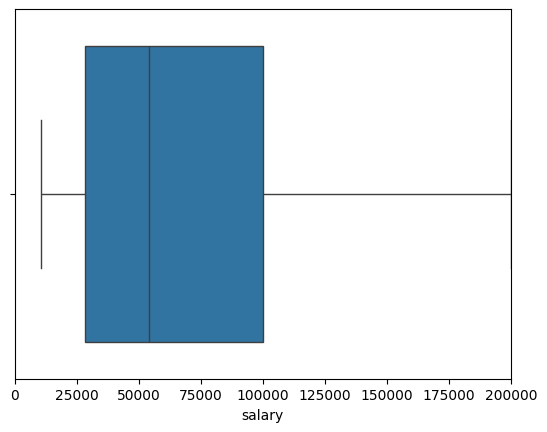

In [39]:
sns.boxplot(x= 'salary', data= grupo_control_rotacion)
plt.xlim(0, 200000); 

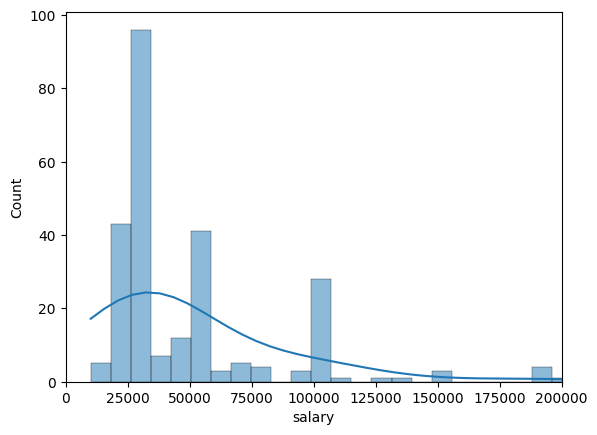

In [37]:
'''Visualización distribución salarios de empleados que se han ido de la empresa.'''
sns.histplot(x= 'salary', data= grupo_variante_rotacion, kde=True)
plt.xlim(0, 200000); 

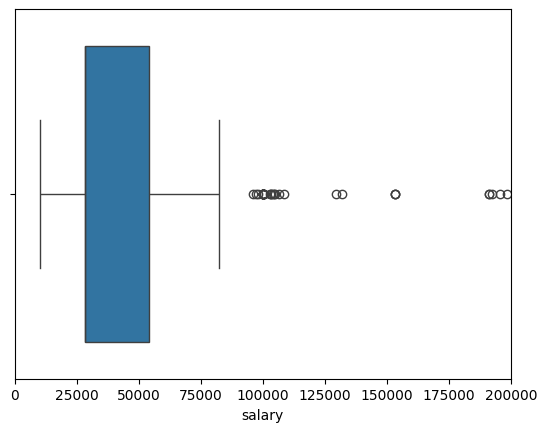

In [41]:
sns.boxplot(x= 'salary', data= grupo_variante_rotacion)
plt.xlim(0, 200000); 

In [17]:
def normalidad(dataframe, columna):

    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

In [18]:
'''¿Siguen los datos salariales de los empleados que siguen en la empresa una distribución normal?'''
normalidad(grupo_control_rotacion, ['salary'])

Para la columna ['salary'] los datos no siguen una distribución normal.


In [19]:
'''¿Siguen los datos salariales de los empleados que se han ido de la empresa una distribución normal?'''
normalidad(grupo_variante_rotacion, ['salary'])

Para la columna ['salary'] los datos no siguen una distribución normal.


In [20]:
def test_man_whitney(dataframe, metricas, grupo_control, grupo_variante, columna_grupos="attrition"):
    # Filtramos los datos por los dos grupos (por ejemplo, "Yes" y "No" para la rotación)
    control = dataframe[dataframe[columna_grupos] == grupo_control]
    variante = dataframe[dataframe[columna_grupos] == grupo_variante]

    # Realizamos la prueba para cada métrica (en este caso, solo salario)
    for metrica in metricas:
        # Extraemos las columnas correspondientes para cada grupo
        metrica_control = control[metrica]
        metrica_variante = variante[metrica]

        # Aplicamos el test de Mann-Whitney
        u_statistic, p_value = stats.mannwhitneyu(metrica_control, metrica_variante)

        if p_value < 0.05:
            print(f"Para {metrica}, las medianas son diferentes.")
        else:
            print(f"Para {metrica}, las medianas son iguales.")

# Llamamos a la función
test_man_whitney(df, ['salary'], 'No', 'Yes')  

Para salary, las medianas son diferentes.


### Rechazamos la hipótesis nula y afirmarmos que existe una relación entre el salario y la rotación de empleados.

In [ ]:
full_time = df[df['standard_hours'] == 'Full Time']

In [ ]:
part_time = df[df['standard_hours'] == 'Part Time']

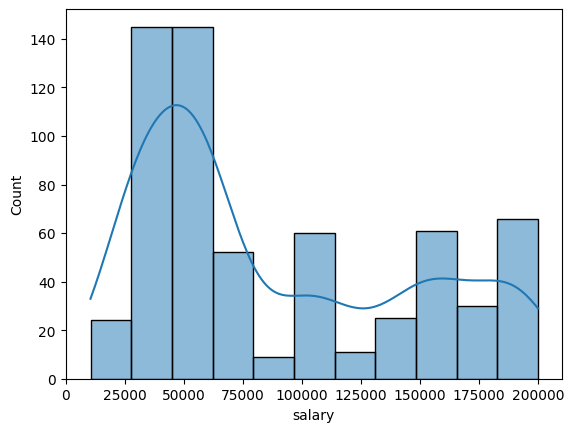

In [54]:
sns.histplot(x= 'salary', data= full_time, kde=True)
plt.xlim(0, 210000); 

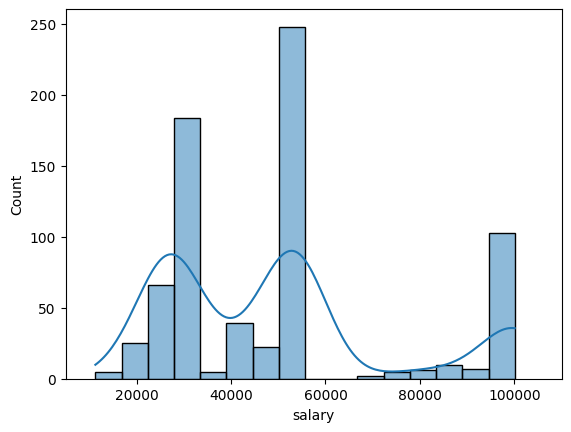

In [57]:
sns.histplot(x= 'salary', data= part_time, kde= True)
plt.xlim(5000, 110000); 

### Hacemos la prueba de M Whitney por separado, ya que no sabemos el equivalente del salario full time para los que trabajan a media jornada y podría afectar sobre cómo están distribuidos los salarios.

In [ ]:
# Prueba de Man Whitney para ver la relación entre el salario de los empleados que se han ido full time y la rotación:

test_man_whitney(full_time, ['salary'], 'No', 'Yes') 

ValueError: `x` and `y` must be of nonzero size.

In [26]:
# Prueba de Man Whitney para ver la relación entre el salario de los empleados part time y la rotación:

test_man_whitney(part_time, ['salary'], 'No', 'Yes') 

Para salary, las medianas son diferentes.
